First we need to read the data. I have downloaded the data and unzip into an `insurance.csv` file. You can find the original data at https://www.kaggle.com/datasets/mirichoi0218/insurance. Here are the meaning of each column, in case you need a quick reference:
- age: The number of age
- sex: Gender
- bmi: Body mass index, measure using the formula (kg / m ^ 2), where kg is the weight in kilogram, and m is the height in meter.
- children: The number of children covered by health insurance / the number of dependent
- smoker: Smoking or not
- region: The living place in the US, consists of northeast, southeast, northwest, southwest.
- charges: Individual medical cost billed by health insurance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

from scipy.stats import t

import statsmodels.api as sm

import seaborn as sns

data = pd.read_csv("insurance.csv")

We need to check if there's any missing or NA values.

In [2]:
data.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

So there's no missing data.

Need, we will see some descriptive statistics of the dataset.

First, the numerical attributes.

In [3]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Then the categorical attributes.

In [4]:
data.describe(include="object")

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


And plot all numeric features as histograms.

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

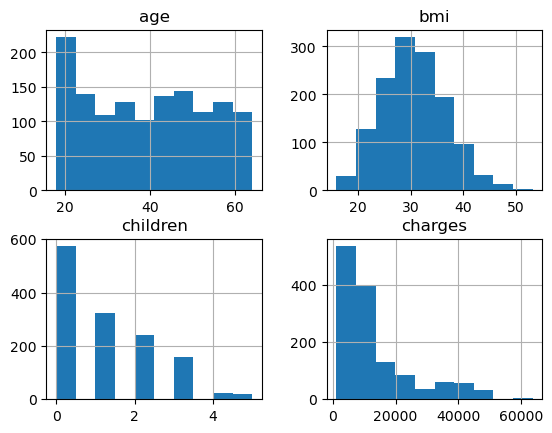

In [5]:
data.hist()

In [6]:
data.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

But enough data snipping! We now need to split the dataset into training and validation set, and put the validation set aside. Since there are 1388 records, I will use 200, which is about 21.61% of the dataset as the validation set.

In [7]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(data, test_size=200, random_state=42)
X_train = train.drop("charges", axis=1)
y_train = train["charges"]

Here I define two *pipeline*, which are used to act as convenient functions to process input features.

In [8]:
num_pipeline = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")
)

num_columns = ["age", "bmi"]
cat_columns = ["sex", "children", "smoker", "region"]

preprocessing = make_column_transformer(
    (num_pipeline, num_columns),
    (cat_pipeline, cat_columns),
)

We preprocess the train set.

In [9]:
X_train_preprocessed = preprocessing.fit_transform(X_train)

Convert to a `pd.DataFrame` for the sake of visualization.

In [10]:
X_train_preprocessed_dataframe = pd.DataFrame(
    X_train_preprocessed,
    index=X_train.index,
    columns=preprocessing.get_feature_names_out(),
)
X_train_preprocessed_dataframe.head()

,pipeline-1__age,pipeline-1__bmi,pipeline-2__sex_female,pipeline-2__sex_male,pipeline-2__children_0,pipeline-2__children_1,pipeline-2__children_2,pipeline-2__children_3,pipeline-2__children_4,pipeline-2__children_5,pipeline-2__smoker_no,pipeline-2__smoker_yes,pipeline-2__region_northeast,pipeline-2__region_northwest,pipeline-2__region_southeast,pipeline-2__region_southwest
1137,-0.940673,-1.357443,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
331,0.906952,-0.519801,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
796,-0.656423,2.233149,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1039,-1.438110,-0.535313,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
261,-1.367048,-0.604709,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


And check the corelation of each feature with regard to the output feature.

In [11]:
train_preprocessed_dataframe = X_train_preprocessed_dataframe.copy(deep=True)
train_preprocessed_dataframe["charges"] = y_train
train_preprocessed_dataframe.corr("pearson")["charges"]

pipeline-1__age                 0.286336
pipeline-1__bmi                 0.200900
pipeline-2__sex_female         -0.056761
pipeline-2__sex_male            0.056761
pipeline-2__children_0         -0.067045
pipeline-2__children_1         -0.031748
pipeline-2__children_2          0.085988
pipeline-2__children_3          0.056387
pipeline-2__children_4          0.003696
pipeline-2__children_5         -0.039626
pipeline-2__smoker_no          -0.780530
pipeline-2__smoker_yes          0.780530
pipeline-2__region_northeast   -0.003090
pipeline-2__region_northwest   -0.050548
pipeline-2__region_southeast    0.083205
pipeline-2__region_southwest   -0.032565
charges                         1.000000
Name: charges, dtype: float64

According to the corelation, the variable with the highest corelation with `charges` is `smoker`, next is `age`, then `bmi`. All other variables don't have noticeable influence on `charges` (correlation < 0.1).

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_preprocessed, y_train)

rfe = RFE(lin_reg, n_features_to_select=10)
rfe.fit(X_train_preprocessed, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [13]:
list(zip(X_train_preprocessed_dataframe.columns, rfe.support_, rfe.ranking_))

[('pipeline-1__age', True, 1),
 ('pipeline-1__bmi', True, 1),
 ('pipeline-2__sex_female', False, 6),
 ('pipeline-2__sex_male', False, 5),
 ('pipeline-2__children_0', True, 1),
 ('pipeline-2__children_1', True, 1),
 ('pipeline-2__children_2', True, 1),
 ('pipeline-2__children_3', False, 2),
 ('pipeline-2__children_4', True, 1),
 ('pipeline-2__children_5', True, 1),
 ('pipeline-2__smoker_no', True, 1),
 ('pipeline-2__smoker_yes', True, 1),
 ('pipeline-2__region_northeast', True, 1),
 ('pipeline-2__region_northwest', False, 7),
 ('pipeline-2__region_southeast', False, 4),
 ('pipeline-2__region_southwest', False, 3)]

In [14]:
# columns where RFE support_ is true
columns = X_train_preprocessed_dataframe.columns[rfe.support_]
columns

Index(['pipeline-1__age', 'pipeline-1__bmi', 'pipeline-2__children_0',
       'pipeline-2__children_1', 'pipeline-2__children_2',
       'pipeline-2__children_4', 'pipeline-2__children_5',
       'pipeline-2__smoker_no', 'pipeline-2__smoker_yes',
       'pipeline-2__region_northeast'],
      dtype='object')

In [15]:
# columns where RFE support_ is false
X_train_preprocessed_dataframe.columns[~rfe.support_]

Index(['pipeline-2__sex_female', 'pipeline-2__sex_male',
       'pipeline-2__children_3', 'pipeline-2__region_northwest',
       'pipeline-2__region_southeast', 'pipeline-2__region_southwest'],
      dtype='object')

# Using `statsmodels` for detailed statistics

In [16]:
X = X_train_preprocessed_dataframe[columns]
X.shape

(1138, 10)

See what happen when I use the library `statsmodels`.

In [17]:
X = sm.add_constant(X)
ols = sm.OLS(y_train, X).fit(use_t=True)

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     364.0
Date:                Tue, 21 May 2024   Prob (F-statistic):               0.00
Time:                        00:19:22   Log-Likelihood:                -11534.
No. Observations:                1138   AIC:                         2.309e+04
Df Residuals:                    1128   BIC:                         2.314e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

# Working with VIF

In [18]:
X = X.drop("const", axis=1)

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["VIF"] = vif["VIF"].round(5)
vif.sort_values(by="VIF", ascending=False)

,Features,VIF
7,pipeline-2__smoker_no,7.49864
2,pipeline-2__children_0,2.69136
8,pipeline-2__smoker_yes,2.55494
3,pipeline-2__children_1,2.32892
4,pipeline-2__children_2,2.07878
5,pipeline-2__children_4,1.15404
6,pipeline-2__children_5,1.11001
1,pipeline-1__bmi,1.03611
9,pipeline-2__region_northeast,1.02539
0,pipeline-1__age,1.02312


Looks like we need to drop `smoker_no`, due to its high VIF value (>5).

In [20]:
# drop smoker_no
X_train_new = X.drop("pipeline-2__smoker_no", axis=1)

In [21]:
X_train_new = sm.add_constant(X_train_new)
ols = sm.OLS(y_train, X_train_new).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     364.0
Date:                Tue, 21 May 2024   Prob (F-statistic):               0.00
Time:                        00:19:22   Log-Likelihood:                -11534.
No. Observations:                1138   AIC:                         2.309e+04
Df Residuals:                    1128   BIC:                         2.314e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [22]:
X = X_train_new.drop("const", axis=1)
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["VIF"] = vif["VIF"].round(5)
vif.sort_values(by="VIF", ascending=False)

,Features,VIF
8,pipeline-2__region_northeast,1.28905
2,pipeline-2__children_0,1.23414
7,pipeline-2__smoker_yes,1.21687
3,pipeline-2__children_1,1.11173
4,pipeline-2__children_2,1.09608
1,pipeline-1__bmi,1.03538
0,pipeline-1__age,1.01777
5,pipeline-2__children_4,1.01215
6,pipeline-2__children_5,1.00308


The VIF values are great, they're all below the 5 threshold. However, the p-values are not so good. Look at them, look like everything we should keep are `age`, `bmi`, and `smoker_yes`.

In [23]:
columns = ["pipeline-1__age", "pipeline-1__bmi", "pipeline-2__smoker_yes"]
X_train_preprocessed_dataframe = X_train_preprocessed_dataframe[columns]
X_train_preprocessed_dataframe.sort_index()

,pipeline-1__age,pipeline-1__bmi,pipeline-2__smoker_yes
0,-1.438110,-0.431629,1.0
1,-1.509173,0.526842,0.0
2,-0.798548,0.401114,0.0
3,-0.443235,-1.279884,0.0
4,-0.514298,-0.271611,0.0
...,...,...,...
1333,0.764827,0.069650,0.0
1334,-1.509173,0.224769,0.0
1335,-1.509173,1.029754,0.0
1336,-1.295985,-0.774523,0.0


In [24]:
X_train = sm.add_constant(X_train_preprocessed_dataframe)
ols = sm.OLS(y_train, X_train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     1075.
Date:                Tue, 21 May 2024   Prob (F-statistic):               0.00
Time:                        00:19:22   Log-Likelihood:                -11543.
No. Observations:                1138   AIC:                         2.309e+04
Df Residuals:                    1134   BIC:                         2.311e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   8430

/home/tan/miniconda3/envs/handsonds/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x1000 with 0 Axes>

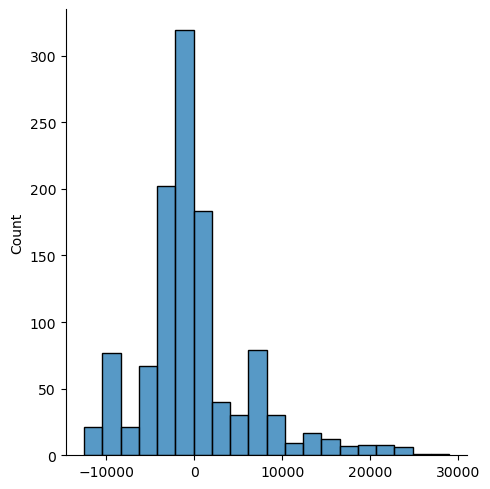

In [25]:
y_predict = ols.predict(X_train)

plt.figure(figsize=(10, 10))
sns.displot((y_train - y_predict), bins=20)
plt.show()

You can see that the residual errors are somewhat normally distributed.

# Check on validation set

In [26]:
X_valid = valid.drop("charges", axis=1)
y_valid = valid["charges"]

In [27]:
X_valid_preprocessed = preprocessing.transform(X_valid)

In [28]:
X_valid_preprocessed_dataframe = pd.DataFrame(
    X_valid_preprocessed,
    index=X_valid.index,
    columns=preprocessing.get_feature_names_out(),
)
X_valid_preprocessed_dataframe.describe()

,pipeline-1__age,pipeline-1__bmi,pipeline-2__sex_female,pipeline-2__sex_male,pipeline-2__children_0,pipeline-2__children_1,pipeline-2__children_2,pipeline-2__children_3,pipeline-2__children_4,pipeline-2__children_5,pipeline-2__smoker_no,pipeline-2__smoker_yes,pipeline-2__region_northeast,pipeline-2__region_northwest,pipeline-2__region_southeast,pipeline-2__region_southwest
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.00000,200.000000,200.000000,200.000000,200.000000
mean,-0.014373,0.131036,0.525000,0.475000,0.405000,0.260000,0.195000,0.120000,0.010000,0.010000,0.79000,0.21000,0.250000,0.240000,0.275000,0.235000
std,0.989283,0.963362,0.500628,0.500628,0.492124,0.439735,0.397195,0.325777,0.099748,0.099748,0.40833,0.40833,0.434099,0.428155,0.447635,0.425063
min,-1.509173,-2.241620,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,-0.869610,-0.597361,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,-0.016860,0.131697,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.764827,0.774828,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.00000,0.250000,0.000000,1.000000,0.000000
max,1.759702,3.598194,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000


In [29]:
# We only use descriptive features known earlier
X_train = X_train.drop("const", axis=1)
X_valid_preprocessed_dataframe = X_valid_preprocessed_dataframe[X_train.columns]

In [31]:
X_valid_preprocessed_dataframe = sm.add_constant(X_valid_preprocessed_dataframe)

In [ ]:
y_predict = ols.predict(X_valid_preprocessed_dataframe)

Finding R-squared and Adjusted R-squared for test set

In [42]:
from sklearn.metrics import r2_score

r2_score(y_valid, y_predict)

0.7887696152480207

In [44]:
# Adjusted R-squared

n, p = X_valid.shape

1 - (1 - r2_score(y_valid, y_predict) * (n - 1) / (n - p - 1))

0.8132909504370783

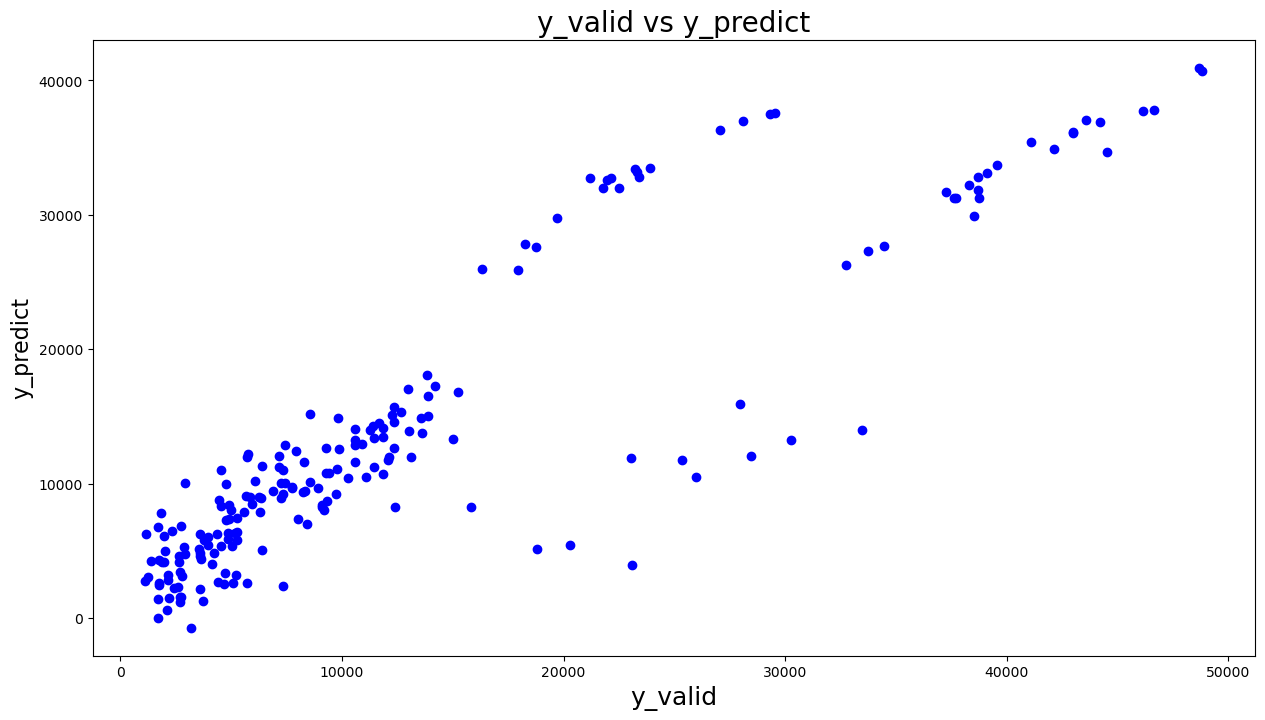

In [47]:
plt.figure(figsize=(15, 8))
plt.scatter(y_valid, y_predict, color="blue")
plt.title("y_valid vs y_predict", fontsize=20)  # Plot heading
plt.xlabel("y_valid", fontsize=18)  # X-label
plt.ylabel("y_predict", fontsize=16)  # Y-label
plt.show()

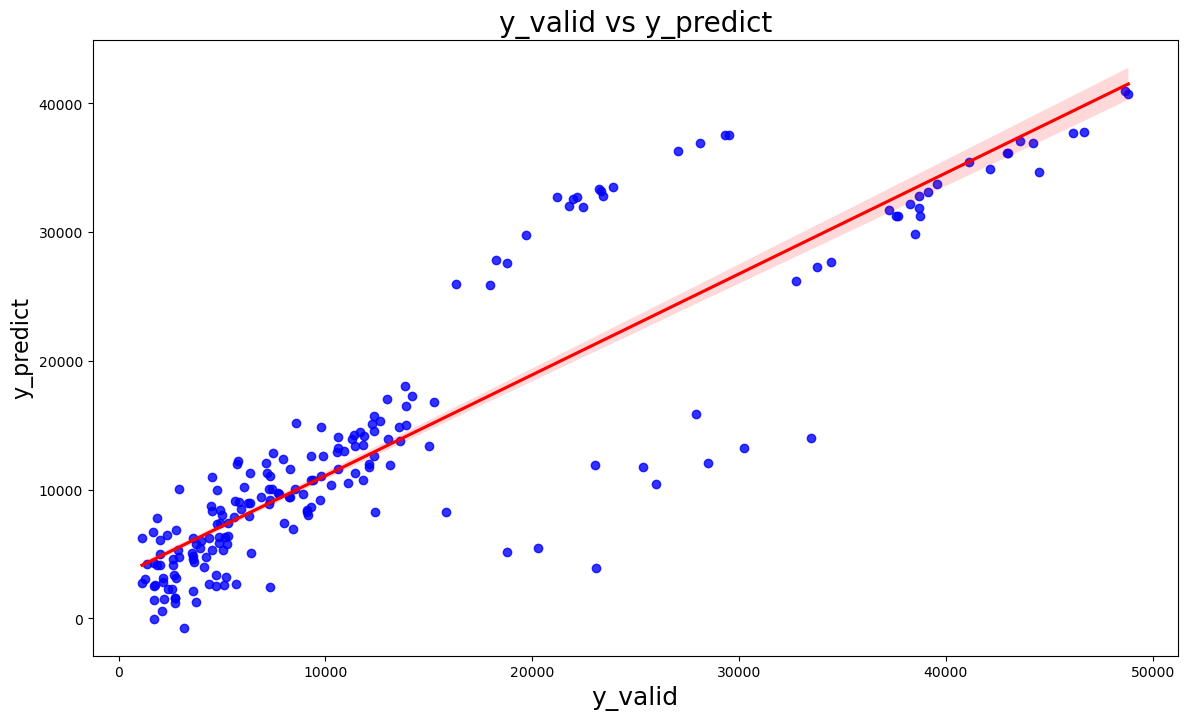

In [48]:
# Regression plot
plt.figure(figsize=(14, 8))
sns.regplot(
    x=y_valid,
    y=y_predict,
    ci=68,
    fit_reg=True,
    scatter_kws={"color": "blue"},
    line_kws={"color": "red"},
)

plt.title("y_valid vs y_predict", fontsize=20)  # Plot heading
plt.xlabel("y_valid", fontsize=18)  # X-label
plt.ylabel("y_predict", fontsize=16)  # Y-label
plt.show()